## IMPORT LIBRAIES

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
print('Seed: 42')




Seed: 42


In [2]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    # display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print('Shape df ', df.shape)
    print('Shape X', X.shape)
    print('Shape y: ', y.shape)
    return X, y

## READ DATASETS

In [3]:
dir = '../splits'
X_train, y_train = read_csv(f'{dir}/raw_train.csv')
X_test, y_test = read_csv(f'{dir}/raw_test.csv')
X_val, y_val = read_csv(f'{dir}/raw_val.csv')

X_val.head(3)

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 14)
Shape X (242, 13)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 14)
Shape X (31, 13)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 14)
Shape X (30, 13)
Shape y:  (30,)


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
0,-1.063621,0.400391,-0.262410,0.089984,-0.713154,0.0,1.000000,0.0,1.0,1.0,0.5,0.0,0.0
1,1.720848,-0.054513,1.368307,-1.809349,1.250048,1.0,1.000000,0.0,1.0,0.0,0.5,1.0,0.0
2,-0.061212,1.082748,-0.338257,0.664201,0.536156,1.0,0.666667,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
# FE Dataset
X_fe_train, y_fe_train = read_csv(f'{dir}/fe_train.csv')
X_fe_test, y_fe_test = read_csv(f'{dir}/fe_test.csv')
X_fe_val, y_fe_val = read_csv(f'{dir}/fe_val.csv')

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 14)
Shape X (242, 13)
Shape y:  (242,)


target
0    7
1    6
Name: count, dtype: int64

Shape df  (13, 14)
Shape X (13, 13)
Shape y:  (13,)


target
0    26
1    22
Name: count, dtype: int64

Shape df  (48, 14)
Shape X (48, 13)
Shape y:  (48,)


In [5]:
# Original + DT
X_dt_train, y_dt_train = read_csv(f'{dir}/dt_train.csv')
X_dt_test, y_dt_test = read_csv(f'{dir}/dt_test.csv')
X_dt_val, y_dt_val = read_csv(f'{dir}/dt_val.csv')

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 11)
Shape X (242, 10)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


In [6]:
# FEATURING + DECISTION TREE
X_fe_dt_train, y_fe_dt_train = read_csv(f'{dir}/fe_dt_train.csv')
X_fe_dt_test, y_fe_dt_test = read_csv(f'{dir}/fe_dt_test.csv')
X_fe_dt_val, y_fe_dt_val = read_csv(f'{dir}/fe_dt_val.csv')

target
0    131
1    111
Name: count, dtype: int64

Shape df  (242, 11)
Shape X (242, 10)
Shape y:  (242,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


In [7]:
# FEATURING + DT + SMOTE
X_smote_train, y_smote_train = read_csv(f'{dir}/smote_fe_train.csv')
X_smote_test, y_smote_test = read_csv(f'{dir}/smote_fe_test.csv')
X_smote_val, y_smote_val = read_csv(f'{dir}/smote_fe_val.csv')

target
1    131
0    131
Name: count, dtype: int64

Shape df  (262, 14)
Shape X (262, 13)
Shape y:  (262,)


target
0    17
1    14
Name: count, dtype: int64

Shape df  (31, 11)
Shape X (31, 10)
Shape y:  (31,)


target
0    16
1    14
Name: count, dtype: int64

Shape df  (30, 11)
Shape X (30, 10)
Shape y:  (30,)


## TỐI ƯU THAM SỐ DÙNG OPTUNA

In [27]:
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import clone

SEED     = 42
N_JOBS   = -1
SCORING  = "accuracy"  # đổi "f1" hoặc "roc_auc" nếu cần
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# ===== Suggest spaces cho 6 model =====
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier

def suggest_rf(trial):
    return RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 300, 900, step=300),
        max_depth=trial.suggest_categorical("max_depth", [None, 12, 20, 30]),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
        random_state=SEED, n_jobs=N_JOBS
    )

def suggest_adb(trial):

    return AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=SEED),
        n_estimators=trial.suggest_int("n_estimators", 200, 800, step=200),
        learning_rate=trial.suggest_float("learning_rate", 0.03, 0.3, log=True),
        random_state=SEED
    )

def suggest_gb(trial):
    return GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 200, 800, step=200),
        learning_rate=trial.suggest_float("learning_rate", 0.03, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 5),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 3),
        random_state=SEED
    )

def suggest_xgb(trial):
    return XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 300, 1000, step=100),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.5, 2.0),
        n_jobs=N_JOBS, random_state=SEED, eval_metric="logloss", tree_method="hist"
    )

def suggest_lgbm(trial):
    return LGBMClassifier(
        verbose=-1,
        n_estimators=trial.suggest_int("n_estimators", 300, 1000, step=100),
        num_leaves=trial.suggest_int("num_leaves", 31, 255, step=32),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        min_child_samples=trial.suggest_int("min_child_samples", 5, 40),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.7, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 1.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.5, 2.0),
        n_jobs=N_JOBS, random_state=SEED
    )

def suggest_cat(trial):
    return CatBoostClassifier(
        n_estimators=trial.suggest_int("n_estimators", 400, 1200, step=200),
        depth=trial.suggest_int("depth", 4, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1.0, 6.0),
        subsample=trial.suggest_float("subsample", 0.7, 1.0),
        random_state=SEED, verbose=False
    )

SUGGESTERS = {
    "rf":   suggest_rf,
    "adb":  suggest_adb,
    "gb":   suggest_gb,
    "xgb":  suggest_xgb,
    "lgbm": suggest_lgbm,
    "cat":  suggest_cat,
}

def optuna_tune_simple(model_key, X, y, n_trials=40, scoring=SCORING):
    suggest_fn = SUGGESTERS[model_key]

    def objective(trial):
        est = suggest_fn(trial)
        score = cross_val_score(est, X, y, cv=5, scoring=scoring,n_jobs=N_JOBS).mean()
        return score

    study = optuna.create_study(direction="maximize", study_name=f"{model_key}_simple")
    study.optimize(objective, n_trials=n_trials)

    best_est = suggest_fn(study.best_trial)
    best_est.fit(X, y)
    return {
        "name": model_key,
        "best_score": study.best_value,
        "best_params": study.best_trial.params,
        "best_estimator": best_est
    }

# === Gọi ví dụ:
# out_lgbm = optuna_tune_simple("lgbm", X_train, y_train, n_trials=40, scoring="accuracy")
# out_xgb  = optuna_tune_simple("xgb",  X_train, y_train)
# out_cat  = optuna_tune_simple("cat",  X_train, y_train)


In [28]:
def calc_results(ranked, X_test, y_test, X_val, y_val):
    results = {}
    for r in ranked:
        results[r['name']] = {
            'val': accuracy_score(y_val, r['best_estimator'].predict(X_val)),
            'test': accuracy_score(y_test, r['best_estimator'].predict(X_test)),
        }
    # print(results)
    return results

In [40]:
def visualize(results, data_name=''):
    algos = list(results.keys())
    val_scores = [results[a]['val'] for a in algos]
    test_scores = [results[a]['test'] for a in algos]

    x = np.arange(len(algos))
    width = 0.38
    fig, ax = plt.subplots()
    b1 = ax.bar(x - width / 2, val_scores, width, label='Validation Accuracy')
    b2 = ax.bar(x + width / 2, test_scores, width, label='Test Accuracy')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Algorithms')
    ax.set_title(f'{data_name} Validation vs Test Scores by Algorithm')
    ax.set_xticks(x)
    ax.set_xticklabels(algos)
    ax.legend()

    def annotate(bars):
        for bar in bars:
            h = bar.get_height()
            ax.annotate('{:.2f}'.format(h), (bar.get_x() + bar.get_width()/ 2, h),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom')
    annotate(b1)
    annotate(b2)
    plt.show()

## ORIGINAL DATASET

In [30]:
# === Gọi ví dụ:
out_lgbm = optuna_tune_simple("lgbm", X_train, y_train, n_trials=50, scoring="accuracy")
out_cat  = optuna_tune_simple("cat",  X_train, y_train)

[I 2025-10-02 13:37:33,332] A new study created in memory with name: lgbm_simple
[I 2025-10-02 13:37:41,492] Trial 0 finished with value: 0.8014455782312926 and parameters: {'n_estimators': 900, 'num_leaves': 127, 'learning_rate': 0.11414911519277716, 'min_child_samples': 37, 'subsample': 0.7430725316755081, 'colsample_bytree': 0.8982690204466757, 'reg_alpha': 0.10807978941102969, 'reg_lambda': 1.797179349010047}. Best is trial 0 with value: 0.8014455782312926.
[I 2025-10-02 13:37:44,482] Trial 1 finished with value: 0.79328231292517 and parameters: {'n_estimators': 400, 'num_leaves': 31, 'learning_rate': 0.15927512724821707, 'min_child_samples': 25, 'subsample': 0.728072290035051, 'colsample_bytree': 0.7829701051068193, 'reg_alpha': 0.302758119306752, 'reg_lambda': 1.1180411821427583}. Best is trial 0 with value: 0.8014455782312926.
[I 2025-10-02 13:37:47,357] Trial 2 finished with value: 0.8014455782312926 and parameters: {'n_estimators': 300, 'num_leaves': 159, 'learning_rate': 0.05

In [31]:
out_xgb  = optuna_tune_simple("xgb",  X_train, y_train)

[I 2025-10-02 13:42:35,697] A new study created in memory with name: xgb_simple
[I 2025-10-02 13:42:41,428] Trial 0 finished with value: 0.7972789115646258 and parameters: {'n_estimators': 900, 'max_depth': 5, 'learning_rate': 0.02053968367219193, 'subsample': 0.7315237366095565, 'colsample_bytree': 0.9261099549174255, 'reg_alpha': 0.5761406258911163, 'reg_lambda': 0.618994862774295}. Best is trial 0 with value: 0.7972789115646258.
[I 2025-10-02 13:42:43,769] Trial 1 finished with value: 0.8013605442176871 and parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.09528007633950394, 'subsample': 0.8609195769274559, 'colsample_bytree': 0.8946291419486162, 'reg_alpha': 0.9964898111478593, 'reg_lambda': 1.4482586179778938}. Best is trial 1 with value: 0.8013605442176871.
[I 2025-10-02 13:42:57,309] Trial 2 finished with value: 0.78078231292517 and parameters: {'n_estimators': 900, 'max_depth': 7, 'learning_rate': 0.16527285740317332, 'subsample': 0.8715433405873897, 'colsamp

In [26]:
out_rf = optuna_tune_simple("rf", X_train, y_train)
out_gb = optuna_tune_simple('gb', X_train, y_train)

[I 2025-10-02 13:31:23,568] A new study created in memory with name: rf_simple
[I 2025-10-02 13:31:25,778] Trial 0 finished with value: 0.8180272108843537 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8180272108843537.
[I 2025-10-02 13:31:28,279] Trial 1 finished with value: 0.8180272108843537 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8180272108843537.
[I 2025-10-02 13:31:38,759] Trial 2 finished with value: 0.8179421768707481 and parameters: {'n_estimators': 900, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8180272108843537.
[I 2025-10-02 13:31:44,161] Trial 3 finished with value: 0.8096938775510203 and parameters: {'n_estimators': 900, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8180272108843537.
[I 2025-10

In [11]:
out_ada = optuna_tune_simple('adb', X_train, y_train, n_trials=50)

[I 2025-10-02 13:10:20,233] A new study created in memory with name: adb_simple
[I 2025-10-02 13:10:39,503] Trial 0 finished with value: 0.8141156462585034 and parameters: {'n_estimators': 600, 'learning_rate': 0.05436236530386764}. Best is trial 0 with value: 0.8141156462585034.
[I 2025-10-02 13:10:43,935] Trial 1 finished with value: 0.826530612244898 and parameters: {'n_estimators': 600, 'learning_rate': 0.03155881196279211}. Best is trial 1 with value: 0.826530612244898.
[I 2025-10-02 13:10:48,736] Trial 2 finished with value: 0.789030612244898 and parameters: {'n_estimators': 800, 'learning_rate': 0.22265497018496705}. Best is trial 1 with value: 0.826530612244898.
[I 2025-10-02 13:10:52,300] Trial 3 finished with value: 0.8017857142857144 and parameters: {'n_estimators': 600, 'learning_rate': 0.11050951327930099}. Best is trial 1 with value: 0.826530612244898.
[I 2025-10-02 13:10:53,601] Trial 4 finished with value: 0.8058673469387754 and parameters: {'n_estimators': 600, 'learni

In [32]:
ranked = sorted([out_ada, out_rf, out_gb, out_lgbm, out_xgb, out_cat], key=lambda x: x["best_score"], reverse=True)

In [33]:
raw_results = calc_results(ranked, X_test, y_test, X_val, y_val)

In [34]:
raw_results

{'adb': {'val': 0.9666666666666667, 'test': 0.8387096774193549},
 'lgbm': {'val': 0.9333333333333333, 'test': 0.8709677419354839},
 'cat': {'val': 0.9, 'test': 0.8064516129032258},
 'rf': {'val': 0.9333333333333333, 'test': 0.8709677419354839},
 'xgb': {'val': 0.9333333333333333, 'test': 0.8709677419354839},
 'gb': {'val': 0.9333333333333333, 'test': 0.9032258064516129}}

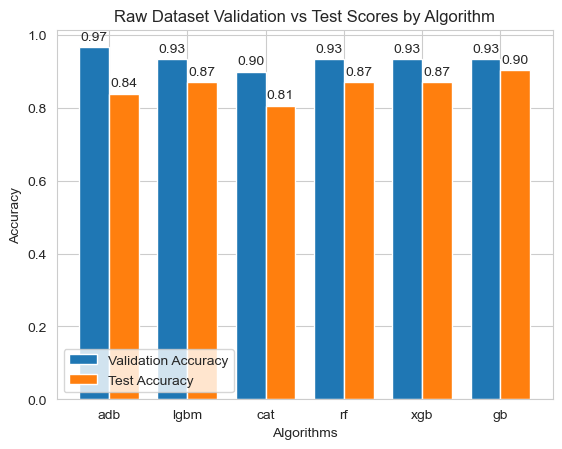

In [41]:
visualize(raw_results, 'Raw Dataset')

In [42]:
for r in ranked:
    print(r['best_estimator'])

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.03729717290662577, n_estimators=200,
                   random_state=42)
LGBMClassifier(colsample_bytree=0.8062473945344163,
               learning_rate=0.024332353079705077, min_child_samples=38,
               n_estimators=700, n_jobs=-1, num_leaves=127, random_state=42,
               reg_alpha=0.5410345586666022, reg_lambda=0.8011381093354967,
               subsample=0.7636828373411673, verbose=-1)
RandomForestClassifier(max_depth=12, min_samples_split=7, n_estimators=900,
                       n_jobs=-1, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7980976532947479, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feat

## DT DATASET

In [ ]:
out_dt_lgbm = optuna_tune_simple("lgbm", X_train, y_dt_train, n_trials=40, scoring="accuracy")
out_dt_xgb  = optuna_tune_simple("xgb",  X_dt_train, y_dt_train)
out_dt_cat  = optuna_tune_simple("cat",  X_dt_train, y_dt_train)
out_dt_rf = optuna_tune_simple("rf", X_dt_train, y_dt_train)
out_dt_gb = optuna_tune_simple('gb', X_dt_train, y_dt_train)
out_dt_ada = optuna_tune_simple('adb', X_dt_train, y_dt_train)

In [24]:
dt_ranked = sorted([out_dt_ada, out_dt_rf, out_dt_gb, out_dt_lgbm, out_dt_xgb, out_dt_cat], key=lambda x: x["best_score"], reverse=True)

NameError: name 'out_dt_ada' is not defined

In [ ]:
dt_results = calc_results(dt_ranked, X_dt_test, y_dt_test, X_dt_val, y_dt_val)

In [ ]:
visualize(dt_results, 'DT Dataset')

## FE DATASET

out_fe_lgbm = optuna_tune_simple("lgbm", X_fe_train, y_fe_train, n_trials=40, scoring="accuracy")
out_fe_cat  = optuna_tune_simple("cat",  X_fe_train, y_fe_train)
out_fe_xgb  = optuna_tune_simple("xgb",  X_fe_train, y_fe_train)
out_fe_rf   = optuna_tune_simple("rf",   X_fe_train, y_fe_train)
out_fe_gb   = optuna_tune_simple('gb',   X_fe_train, y_fe_train)
out_fe_ada  = optuna_tune_simple('adb',  X_fe_train, y_fe_train)

In [ ]:
fe_ranked = sorted([out_fe_ada, out_fe_rf, out_fe_gb, out_fe_lgbm, out_fe_xgb, out_fe_cat],
                   key=lambda x: x["best_score"], reverse=True)


In [ ]:
fe_results = calc_results(fe_ranked, X_fe_test, y_fe_test, X_fe_val, y_fe_val)

In [ ]:
visualize(fe_results, 'FE Dataset')

## FE + DT DATASET

In [ ]:
out_fe_dt_lgbm = optuna_tune_simple("lgbm", X_fe_dt_train, y_fe_dt_train, n_trials=40, scoring="accuracy")
out_fe_dt_cat  = optuna_tune_simple("cat",  X_fe_dt_train, y_fe_dt_train)
out_fe_dt_xgb  = optuna_tune_simple("xgb",  X_fe_dt_train, y_fe_dt_train)
out_fe_dt_rf   = optuna_tune_simple("rf",   X_fe_dt_train, y_fe_dt_train)
out_fe_dt_gb   = optuna_tune_simple('gb',   X_fe_dt_train, y_fe_dt_train)
out_fe_dt_ada  = optuna_tune_simple('adb',  X_fe_dt_train, y_fe_dt_train)

In [ ]:
fe_dt_ranked = sorted([out_fe_dt_ada, out_fe_dt_rf, out_fe_dt_gb, out_fe_dt_lgbm, out_fe_dt_xgb, out_fe_dt_cat],
                      key=lambda x: x["best_score"], reverse=True)


In [ ]:
fe_dt_results = calc_results(fe_dt_ranked, X_fe_dt_test, y_fe_dt_test, X_fe_dt_val, y_fe_dt_val)

In [ ]:
visualize(fe_dt_results, 'FE + DT Dataset')

## SMOTE DATASET

In [ ]:
out_fe_sm_lgbm = optuna_tune_simple("lgbm", X_smote_train, y_smote_train, n_trials=40, scoring="accuracy")
out_fe_sm_cat  = optuna_tune_simple("cat",  X_smote_train, y_smote_train)
out_fe_sm_xgb  = optuna_tune_simple("xgb",  X_smote_train, y_smote_train)
out_fe_sm_rf   = optuna_tune_simple("rf",   X_smote_train, y_smote_train)
out_fe_sm_gb   = optuna_tune_simple('gb',   X_smote_train, y_smote_train)
out_fe_sm_ada  = optuna_tune_simple('adb',  X_smote_train, y_smote_train)


In [ ]:
fe_sm_ranked = sorted([out_fe_sm_ada, out_fe_sm_rf, out_fe_sm_gb, out_fe_sm_lgbm, out_fe_sm_xgb, out_fe_sm_cat],
                      key=lambda x: x["best_score"], reverse=True)


In [ ]:
fe_sm_results = calc_results(fe_sm_ranked, X_smote_test, y_smote_test, X_smote_val, y_smote_val)

In [ ]:
visualize(fe_sm_results, 'FE + SMOTE (train)')


## RESULT REPORT

In [ ]:
# Aggregate best estimators across datasets and save to CSV
from pathlib import Path
import json
import pandas as pd

# Map dataset -> variable prefix used in your notebook variables
dataset_prefixes = {
    'raw':   '',        # e.g., out_ada, out_rf, ...
    'dt':    'dt',      # e.g., out_dt_ada, out_dt_rf, ...
    'fe':    'fe',      # e.g., out_fe_ada, ...
    'fe_dt': 'fe_dt',   # e.g., out_fe_dt_ada, ...
    'fe_sm': 'fe_sm',   # e.g., out_fe_sm_ada, ...
}

# 6 algorithms (matching keys used in SUGGESTERS)
alg_order = ['adb', 'rf', 'gb', 'lgbm', 'xgb', 'cat']

# Map algorithm key -> suffix used in your variable names
suffix_map = {'adb': 'ada', 'rf': 'rf', 'gb': 'gb', 'lgbm': 'lgbm', 'xgb': 'xgb', 'cat': 'cat'}

def get_out(prefix: str, alg: str):
    # Compose variable name e.g., out_fe_dt_ada or out_rf
    varname = f"out_{(prefix + '_') if prefix else ''}{suffix_map[alg]}"
    return globals().get(varname, None)

rows = []
for ds, prefix in dataset_prefixes.items():
    for alg in alg_order:
        out = get_out(prefix, alg)
        if out is None:
            continue
        est = out.get('best_estimator')
        params = out.get('best_params', {})
        score = out.get('best_score', None)
        score_fmt = f"{score:.4f}" if isinstance(score, (int, float)) else str(score)
        est_class = type(est).__name__ if est is not None else ''
        est_repr = (repr(est) if est is not None else '').replace('\n', ' ').replace('\r', ' ')
        print(f"[{ds}] {alg}: score={score_fmt}  estimator={est_class}")

        rows.append({
            'dataset': ds,
            'algorithm': alg,
            'best_score': score,
            'best_params_json': json.dumps(params),
            'estimator_class': est_class,
            'estimator_repr': est_repr
        })

best_df = pd.DataFrame(rows).sort_values(['dataset','algorithm']).reset_index(drop=True)
out_path = Path('../splits') / 'best_estimators_summary.csv'
out_path.parent.mkdir(parents=True, exist_ok=True)
best_df.to_csv(out_path, index=False)
print("Saved:", out_path)
best_df.head()


In [ ]:
# Plot 6 charts: one per algorithm, showing val/test across datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These should be produced earlier via calc_results(...):
# raw_results, dt_results, fe_results, fe_dt_results, fe_sm_results
results_vars = {
    'raw':   'raw_results',
    'dt':    'dt_results',
    'fe':    'fe_results',
    'fe_dt': 'fe_dt_results',
    'fe_sm': 'fe_sm_results',
}

records = []
for ds, varname in results_vars.items():
    res = globals().get(varname, None)
    if res is None:
        continue
    # res expected format: { 'adb': {'val': score, 'test': score}, ... }
    for alg, metrics in res.items():
        if not isinstance(metrics, dict):
            continue
        for split in ['val', 'test']:
            val = metrics.get(split, None)
            if val is None:
                continue
            records.append({'dataset': ds, 'algorithm': alg, 'split': split, 'score': float(val)})

plot_df = pd.DataFrame(records)
alg_names = ['adb', 'rf', 'gb', 'lgbm', 'xgb', 'cat']

fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharey=True)
axes = axes.ravel()

for i, alg in enumerate(alg_names):
    ax = axes[i]
    sub = plot_df[plot_df['algorithm'] == alg]
    if sub.empty:
        ax.set_title(f"{alg.upper()} — no data")
        ax.axis('off')
        continue

    sns.barplot(data=sub, x='dataset', y='score', hue='split', ax=ax, palette=['#4c78a8', '#f58518'])
    ax.set_title(alg.upper())
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

    # annotate bars
    for p in ax.patches:
        h = p.get_height()
        if np.isfinite(h):
            ax.annotate(f"{h:.3f}", (p.get_x() + p.get_width()/2, h), ha='center', va='bottom', fontsize=8)

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, title='Split')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
